
Modello: svc
Cross-Validation Scores (Accuracy): [0.81280788 0.82469136 0.82716049 0.79753086 0.82962963]
Mean Accuracy: 0.82 (+/- 0.02 std)


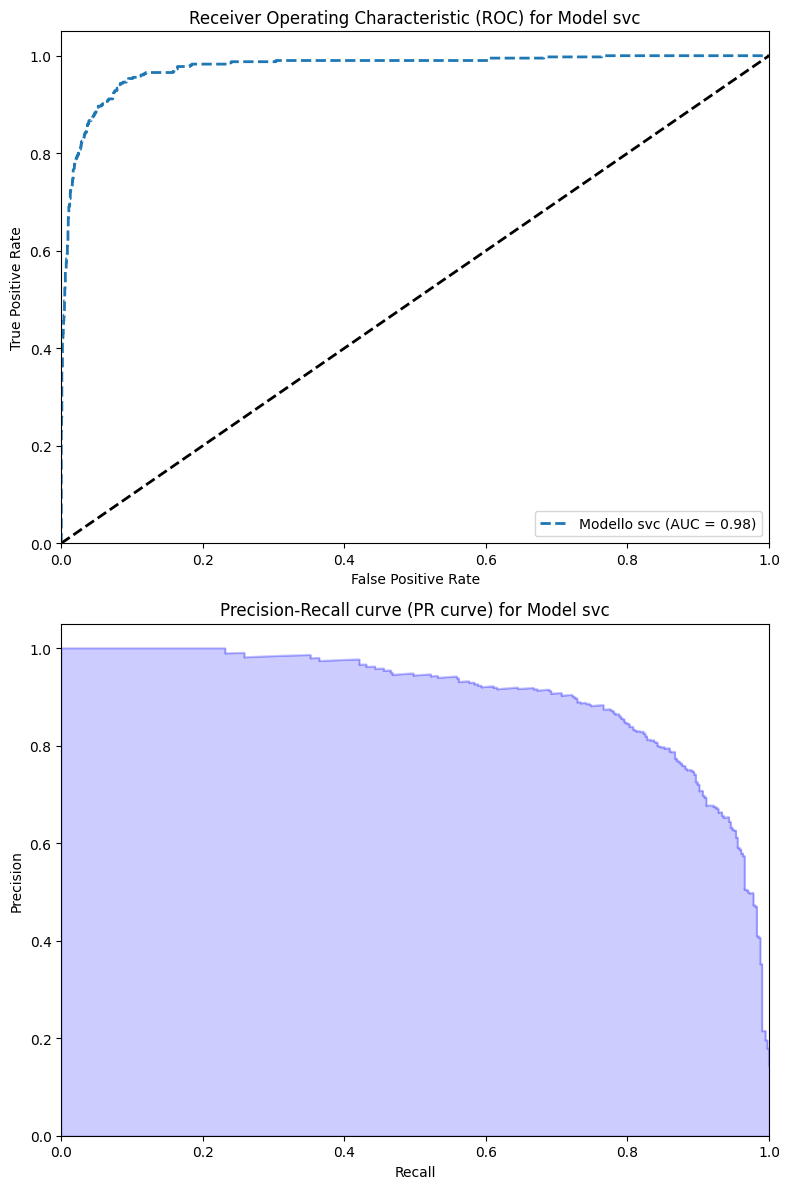

Classe 0:
  Precision: 1.00
  Recall: 0.60
  F1-Score: 0.75
  Accuracy: 0.60


Classe 1:
  Precision: 1.00
  Recall: 0.92
  F1-Score: 0.96
  Accuracy: 0.92


Classe 2:
  Precision: 0.81
  Recall: 0.96
  F1-Score: 0.88
  Accuracy: 0.96


Classe 3:
  Precision: 0.42
  Recall: 0.17
  F1-Score: 0.24
  Accuracy: 0.17


Classe 4:
  Precision: 1.00
  Recall: 0.14
  F1-Score: 0.25
  Accuracy: 0.14


Classe 5:
  Precision: 0.81
  Recall: 0.72
  F1-Score: 0.76
  Accuracy: 0.72


Classe 6:
  Precision: 1.00
  Recall: 0.67
  F1-Score: 0.80
  Accuracy: 0.67


Accuracy: 0.82
AUC for svc: 0.98
PR AUC for svc: 0.81



Modello: sdg
Cross-Validation Scores (Accuracy): [0.80788177 0.80740741 0.81481481 0.79012346 0.83209877]
Mean Accuracy: 0.81 (+/- 0.03 std)


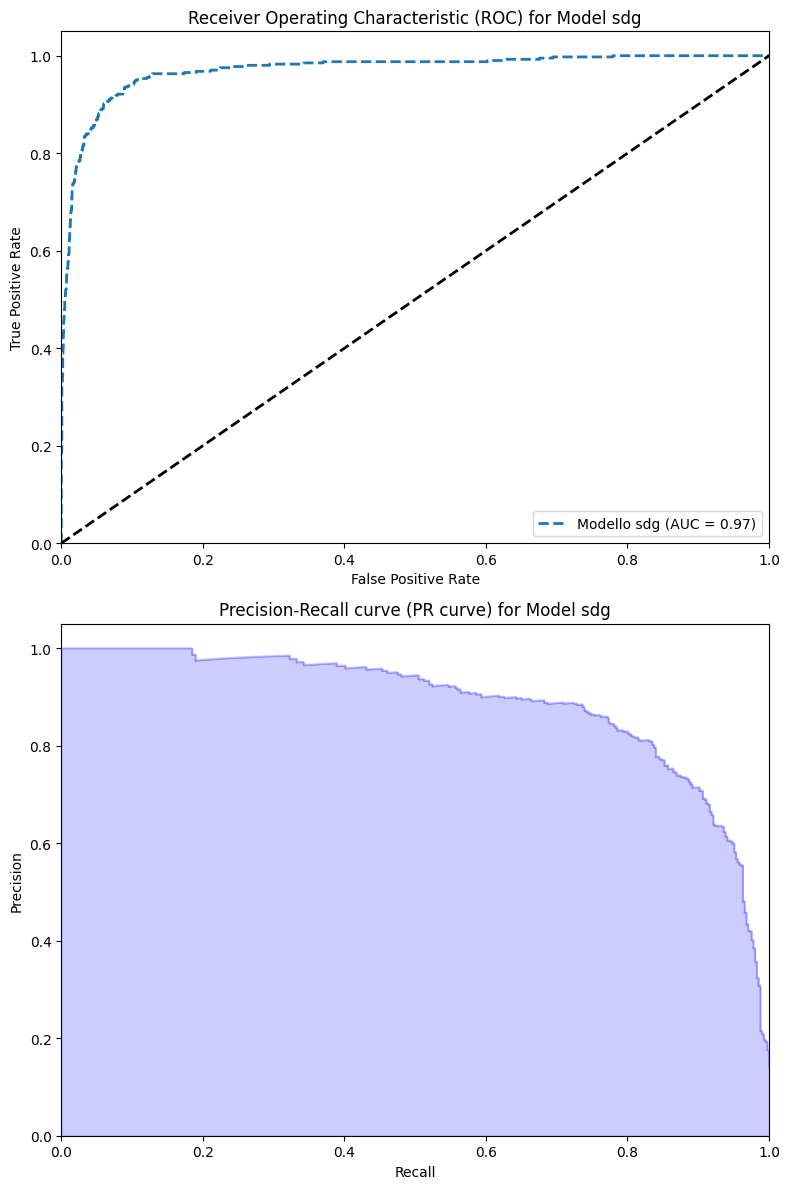

Classe 0:
  Precision: 1.00
  Recall: 0.80
  F1-Score: 0.89
  Accuracy: 0.80


Classe 1:
  Precision: 1.00
  Recall: 0.92
  F1-Score: 0.96
  Accuracy: 0.92


Classe 2:
  Precision: 0.83
  Recall: 0.92
  F1-Score: 0.88
  Accuracy: 0.92


Classe 3:
  Precision: 0.34
  Recall: 0.23
  F1-Score: 0.27
  Accuracy: 0.23


Classe 4:
  Precision: 1.00
  Recall: 0.14
  F1-Score: 0.25
  Accuracy: 0.14


Classe 5:
  Precision: 0.78
  Recall: 0.78
  F1-Score: 0.78
  Accuracy: 0.78


Classe 6:
  Precision: 0.89
  Recall: 0.89
  F1-Score: 0.89
  Accuracy: 0.89


Accuracy: 0.82
AUC for sdg: 0.97
PR AUC for sdg: 0.80




In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

# Read file .csv cleaned
data = pd.read_csv('sample_data/NewSample', sep=";", on_bad_lines='skip')

# Separate the messages and labels
X = data['COMMIT:']
y = data['CATEGORIES:']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Dictionary for memorising measurements
scores = {}

# Configuration of k-fold cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List of models to iterate
models = {
    'svc': OneVsRestClassifier(LinearSVC()),
    'sdg': OneVsRestClassifier(SGDClassifier()),
}

# Itera on all models
for model_key, model in models.items():
    print(f"\nModello: {model_key}")

    # Creates the pipeline for the current model
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', model),
    ])

    # Model training with k-fold cross-validation
    cv_scores = cross_val_score(text_clf, X, y, cv=cv, scoring='accuracy')

    # Calculation of the mean and standard deviation of metrics obtained from cross-validation
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    # Print cross-validation results
    print(f'Cross-Validation Scores (Accuracy): {cv_scores}')
    print(f'Mean Accuracy: {mean_cv_score:.2f} (+/- {2 * std_cv_score:.2f} std)')

    # Model training
    text_clf.fit(X_train, y_train)

    # Prediction on the test set
    y_pred = text_clf.predict(X_test)

    # Calculation of precision, recall, F1-score and accuracy measurements
    metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
    accuracy = accuracy_score(y_test, y_pred)

    # Storage of measurements in the dictionary for the current model only
    scores[model_key] = {'Metrics': metrics, 'Accuracy': accuracy}

    # Calibration of probabilities
    y_score = text_clf.decision_function(X_test)

    # Binarize labels if necessary
    y_test_bin = label_binarize(y_test, classes=text_clf.classes_)

    # Calculates the ROC curve and the area under the ROC curve for the current model
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    # Calculates the precision-recall curve (PR curve) and the area under the PR curve (PR-AUC) for the current model
    precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
    pr_auc = average_precision_score(y_test_bin, y_score)

    # Plot of the two graphs below each other
    plt.figure(figsize=(8, 12))

    # Plot of the ROC curve for the current model
    plt.subplot(2, 1, 1)
    plt.plot(fpr, tpr, label=f'Modello {model_key} (AUC = {roc_auc:.2f})', linestyle='--', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) for Model {model_key}')
    plt.legend(loc="lower right")

    # Plot of the PR curve for the current model
    plt.subplot(2, 1, 2)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve (PR curve) for Model {model_key}')

    plt.tight_layout()
    plt.show()

    # Print measurements for the current model only
    for i in range(len(text_clf.classes_)):
        print(f"Classe {i}:")
        print(f"  Precision: {metrics[0][i]:.2f}")
        print(f"  Recall: {metrics[1][i]:.2f}")
        print(f"  F1-Score: {metrics[2][i]:.2f}")
        # Calculation and printing of accuracy for each class
        class_accuracy = accuracy_score(y_test[y_test == text_clf.classes_[i]], y_pred[y_test == text_clf.classes_[i]])
        print(f"  Accuracy: {class_accuracy:.2f}")

        print("\n")

    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC for {model_key}: {roc_auc:.2f}")
    print(f"PR AUC for {model_key}: {pr_auc:.2f}")
    print("\n")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Classe 0: BUILD, Colore: (0.267004, 0.004874, 0.329415, 1.0)
Classe 1: CI, Colore: (0.275191, 0.194905, 0.496005, 1.0)
Classe 2: CODE, Colore: (0.212395, 0.359683, 0.55171, 1.0)
Classe 3: NO LABEL, Colore: (0.153364, 0.497, 0.557724, 1.0)
Classe 4: PLAN, Colore: (0.122312, 0.633153, 0.530398, 1.0)
Classe 5: RELEASE, Colore: (0.288921, 0.758394, 0.428426, 1.0)
Classe 6: TEST, Colore: (0.626579, 0.854645, 0.223353, 1.0)


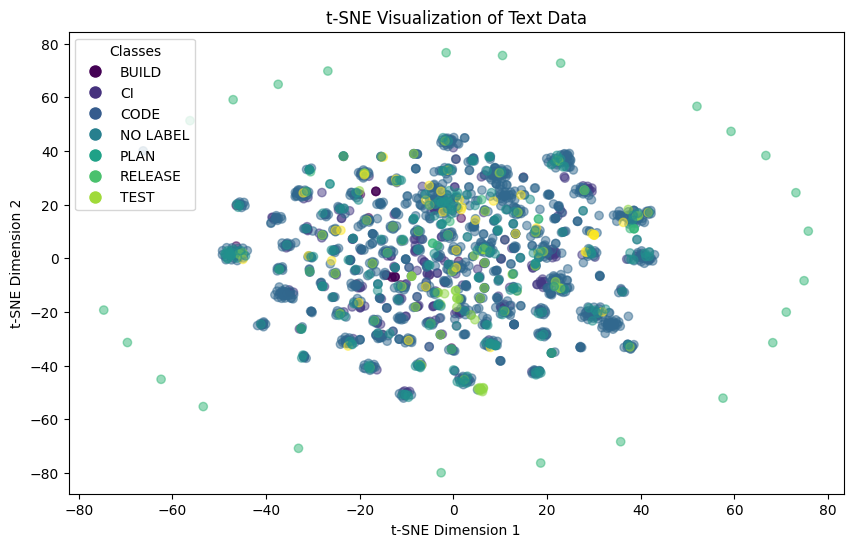

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier

# Read file .csv cleaned
data = pd.read_csv('sample_data/CAMPIONE_COMMITS_MODIFICATO_CSV.csv', sep=";", on_bad_lines='skip')

# Separate the messages and labels
X = data['COMMIT:']
y = data['CATEGORIES:']

# Coding of class labels in numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Mapping between numerical class identifiers and their names
class_mapping = dict(zip(y_encoded, y))

# Division of data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=1, stratify=y_encoded)

# Model SVC
model_svc = OneVsRestClassifier(LinearSVC())

# Creating the model pipeline
model_key = 'svc'
model = model_svc
text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', model),
])

# Model training
text_clf.fit(X, y_encoded)

# Extracting features (embedding) from the model
features = text_clf.named_steps['vect'].transform(X)

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42, init="random")
X_tsne = tsne.fit_transform(features)

# t-SNE visualisation with customised legend
plt.figure(figsize=(10, 6))

# Plot of points
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='viridis', alpha=0.5, marker='o')

# Creating the legend with distinct colours for each class
unique_classes = np.unique(y_encoded)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / len(unique_classes)), markersize=10) for i in unique_classes]
legend1 = plt.legend(handles, [class_mapping[label] for label in unique_classes], title='Classes')

plt.title('t-SNE Visualization of Text Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# I check whether the classes in the legend match the colours of the dots shown in the graph
for i, label in enumerate(unique_classes):
    print(f"Classe {label}: {class_mapping[label]}, Colore: {plt.cm.viridis(i / len(unique_classes))}")

plt.show()
